<a href="https://colab.research.google.com/github/ktw-98/Portfolio/blob/main/Capstone_PD_LQR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install control

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import control
from scipy.linalg import solve_continuous_are


# 0.Open-loop

0-1. 졸업작품 시스템 변수 설정

In [83]:
m1 = 100       # 킥보드 + 탑승자 (kg)
m2 = 1         # 컵홀더 + 음료 (kg)
k1 = 200_000   # 바퀴 강성 (N/m)
k2 = 100       # 컵홀더 강성 (N/m)
c = 15
zeta = c / (2 * np.sqrt(k2 * m2))
f_n = 1/(2*np.pi) * np.sqrt(k2/m2)

v_kmh = 25.0      # km/h
v = v_kmh / 3.6   # m/s

R = 0.1           # 바퀴 반지름 (m)
h = 0.05          # 턱 높이 (m)
g = 9.81          # 중력가속도

0-2. 외란 설정

In [84]:
# 바닥 가진 파라미터
A_road = 0.005                        # 변위
f_road = 2.0                          # 주파수 Hz

# 임펄스 충격 파라미터
t_down1 = 5                           # 충격 시점 1
t_down2 = 15                          # 충격 시점 2
impulse_time = 0.01                   # 임펄스 시간
v_down = np.sqrt(2 * g * h)           # 충격 속도
F_down = m1 * v_down / impulse_time   # 충격량

# 바닥 가진
def road_disp(t):
    return A_road * np.sin(2*np.pi*f_road*t)

def impact_force(t):
    f = 0.0
    if t_down1 <= t <= t_down1 + impulse_time : f += F_down
    if t_down2 <= t <= t_down2 + impulse_time : f += F_down
    return f


0-3. 모델 설정

In [85]:
def model_OL(x, t):
    x1, v1, x2, v2 = x

    # 바닥 입력 + 충격 입력
    r = road_disp(t)
    f_road = k1 * (r - x1)          # 바닥 스프링 힘
    f_impulse  = impact_force(t)         # 충격 펄스
    f_in   = f_road + f_impulse          # m1에 들어가는 총 외력

    dx = x2 - x1
    dv = v2 - v1

    f_k = k2 * dx
    f_c = c * dv
    f_sys = f_k + f_c

    a1 = (f_in + f_sys) / m1
    a2 = (-f_sys) / m2

    return [v1, a1, v2, a2]

0-4. 시뮬레이션

In [86]:
init = [0, 0, 0, 0]
t = np.linspace(0, 20, 10000)
sol = odeint(model_OL, init, t)
x1, v1, x2, v2 = sol.T

stroke_mm = (x2 - x1) * 1000
x2 = x2*1000

print(f'max|stroke_mm| = {np.max(np.abs(stroke_mm)):.2f}')
print(f'max|x2| = {np.max(np.abs(x2)):.2f}mm')
print(f"F_down = {F_down:.1f} N")
print(f'f_n = {f_n:.1f}Hz')

max|stroke_mm| = 32.34
max|x2| = 15.64mm
F_down = 9904.5 N
f_n = 1.6Hz


0-5. 시각화

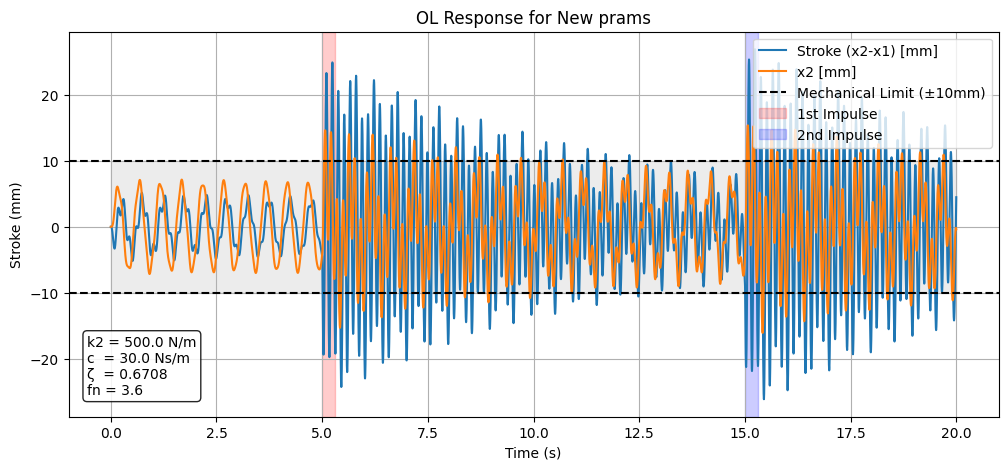

In [96]:
plt.figure(figsize=(12, 5))
plt.plot(t, stroke_mm, linewidth=1.5, label='Stroke (x2-x1) [mm]')
plt.plot(t, x2, linewidth=1.5, label='x2 [mm]')
plt.axhline(y=10, linestyle='--', color='k', label='Mechanical Limit (±10mm)')
plt.axhline(y=-10, linestyle='--', color='k')
plt.fill_between(t, -10, 10, alpha=0.15, color='gray')
plt.axvspan(t_down1, t_down1  +0.3, alpha=0.2, color='red', label='1st Impulse')
plt.axvspan(t_down2, t_down2  +0.3, alpha=0.2, color='blue', label='2nd Impulse')

plt.xlabel('Time (s)')
plt.ylabel('Stroke (mm)')
plt.title('OL Response for New prams')
plt.grid(True)
plt.legend(loc='upper right')

param_text = (
    f"k2 = {k2:.1f} N/m\n"
    f"c  = {c:.1f} Ns/m\n"
    f"ζ  = {zeta:.4f}\n"
    f"fn = {f_n:.1f}"
)
ax = plt.gca()
ax.text(
    0.02, 0.05, param_text,
    transform=ax.transAxes,
    va='bottom', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
)
plt.show()

#1. OL - 시스템 파라미터 변화 + 램프 입력

1-1. 변수 설정
- k2 = 500
- c = 30

In [97]:
k2 = 500       # 컵홀더 강성 (N/m)
c = 30
zeta = c / (2 * np.sqrt(k2 * m2))
f_n = 1/(2*np.pi) * np.sqrt(k2/m2)

1-4. 시뮬레이션

In [98]:
init = [0, 0, 0, 0]
t = np.linspace(0, 20, 10000)
sol = odeint(model_OL, init, t)
x1, v1, x2, v2 = sol.T

stroke_mm = (x2 - x1) * 1000
x2 = x2*1000

print(f'max|stroke_mm| = {np.max(np.abs(stroke_mm)):.2f}')
print(f'max|x2| = {np.max(np.abs(x2)):.2f}mm')
print(f"F_down = {F_down:.1f} N")
print(f'f_n = {f_n:.1f}Hz')

max|stroke_mm| = 26.67
max|x2| = 25.29mm
F_down = 9904.5 N
f_n = 3.6Hz


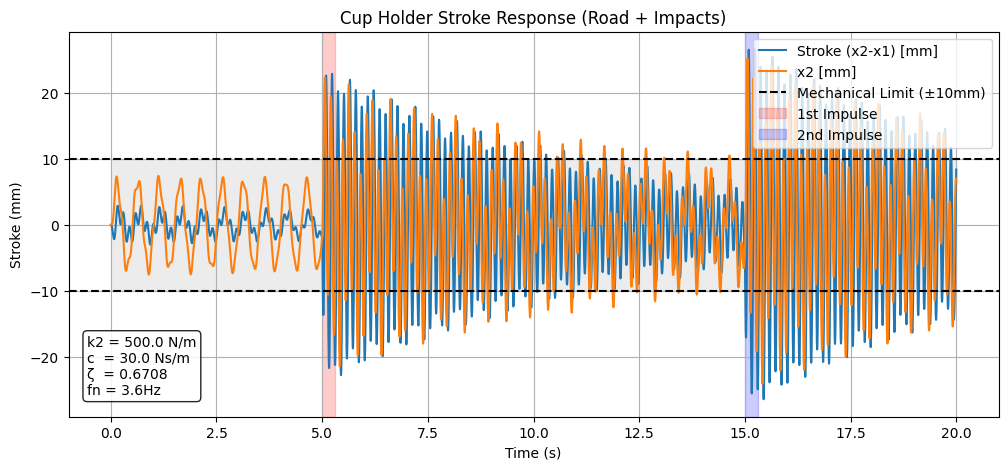

In [99]:
plt.figure(figsize=(12, 5))
plt.plot(t, stroke_mm, linewidth=1.5, label='Stroke (x2-x1) [mm]')
plt.plot(t, x2, linewidth=1.5, label='x2 [mm]')
plt.axhline(y=10, linestyle='--', color='k', label='Mechanical Limit (±10mm)')
plt.axhline(y=-10, linestyle='--', color='k')
plt.fill_between(t, -10, 10, alpha=0.15, color='gray')
plt.axvspan(t_down1, t_down1  +0.3, alpha=0.2, color='red', label='1st Impulse')
plt.axvspan(t_down2, t_down2  +0.3, alpha=0.2, color='blue', label='2nd Impulse')

plt.xlabel('Time (s)')
plt.ylabel('Stroke (mm)')
plt.title('Cup Holder Stroke Response (Road + Impacts)')
plt.grid(True)
plt.legend(loc='upper right')

param_text = (
    f"k2 = {k2:.1f} N/m\n"
    f"c  = {c:.1f} Ns/m\n"
    f"ζ  = {zeta:.4f}\n"
    f"fn = {f_n:.1f}Hz"
)
ax = plt.gca()
ax.text(
    0.02, 0.05, param_text,
    transform=ax.transAxes,
    va='bottom', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
)
plt.show()

# 2. PID
- 시스템 변수, 외란은 Open-loop와 동일하게 사용

2.1 $f_n, \zeta$ 기준으로 $K_p, K_d$ 설정

In [100]:
f_n_des = 2
zeta_des = 0.7

omega_n = 2*np.pi*f_n_des

Kp = m2 * omega_n**2 - k2
k_eff = k2 + Kp

Kd = 2*zeta_des*np.sqrt(k_eff*m2) - c
c_eff = c + Kd

print("Kp =", Kp)
print("Kd =", Kd)
print("k_eff =", k_eff)
print('c_eff =', c_eff)

Kp = -342.0863295825703
Kd = -12.407081139897159
k_eff = 157.91367041742973
c_eff = 17.59291886010284


2.2 모델 설정

In [105]:
def model_PD(x, t):
    x1, v1, x2, v2 = x

    # 외란 입력
    r = road_disp(t)
    f_road = k1 * (r - x1)          # 바닥 스프링 힘
    f_impulse  = impact_force(t)         # 충격 펄스
    f_in   = f_road + f_impulse          # m1에 들어가는 총 외력

    # 스트로크와 속도
    s = x2 - x1
    sdot = v2 - v1

    # PD 제어 (m2에만 작용)
    u = -Kp*s - Kd*sdot

    dx = x2 - x1
    dv = v2 - v1

    f_k = k2 * dx
    f_c = c * dv
    f_sys = f_k + f_c

    a1 = (f_in + f_sys) / m1
    a2 = (-f_sys) / m2

    return [v1, a1, v2, a2]


2.3 시뮬레이션

In [106]:
init = [0, 0, 0, 0]
t = np.linspace(0, 20, 10000)
sol = odeint(model_PD, init, t)
x1, v1, x2, v2 = sol.T

stroke_mm = (x2 - x1) * 1000
x2 = x2*1000

print(f'max|stroke_mm| = {np.max(np.abs(stroke_mm)):.2f}')
print(f'max|x2| = {np.max(np.abs(x2)):.2f}mm')
print(f"F_down = {F_down:.1f} N")
print(f'f_n_des = {f_n_des:.1f}Hz')

max|stroke_mm| = 26.67
max|x2| = 25.29mm
F_down = 9904.5 N
f_n_des = 2.0Hz


2.4 시각화

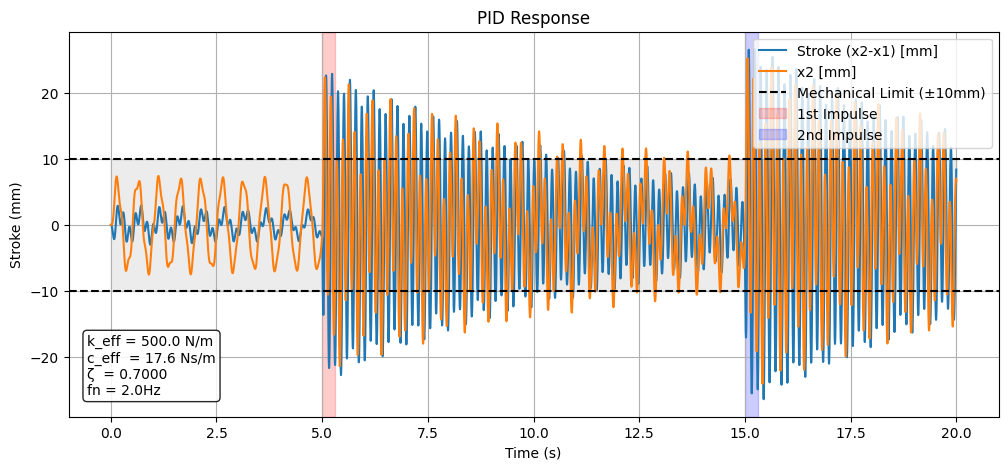

In [107]:
plt.figure(figsize=(12, 5))
plt.plot(t, stroke_mm, linewidth=1.5, label='Stroke (x2-x1) [mm]')
plt.plot(t, x2, linewidth=1.5, label='x2 [mm]')
plt.axhline(y=10, linestyle='--', color='k', label='Mechanical Limit (±10mm)')
plt.axhline(y=-10, linestyle='--', color='k')
plt.fill_between(t, -10, 10, alpha=0.15, color='gray')
plt.axvspan(t_down1, t_down1  +0.3, alpha=0.2, color='red', label='1st Impulse')
plt.axvspan(t_down2, t_down2  +0.3, alpha=0.2, color='blue', label='2nd Impulse')

plt.xlabel('Time (s)')
plt.ylabel('Stroke (mm)')
plt.title('PID Response')
plt.grid(True)
plt.legend(loc='upper right')

param_text = (
    f"k_eff = {k2:.1f} N/m\n"
    f"c_eff  = {c_eff:.1f} Ns/m\n"
    f"ζ  = {zeta_des:.4f}\n"
    f"fn = {f_n_des:.1f}Hz"
)
ax = plt.gca()
ax.text(
    0.02, 0.05, param_text,
    transform=ax.transAxes,
    va='bottom', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
)
plt.show()

2.5 상태 공간 표현 구현한 뒤 마진 확인

$$
\left\{
\begin{aligned}
\dot{x} &= A x + B_u
\quad = \quad
A x + B
\begin{bmatrix}
u \\
r \\
w
\end{bmatrix} \\[8pt]
y &= C x + D_u
\quad = \quad
C x + D
\begin{bmatrix}
u \\
r \\
w
\end{bmatrix}
\end{aligned}
\right.
$$


In [109]:
A = np.array([
    [0,             1,          0,              0],
    [-(k1+k2)/m1,  -c/m1,      k2/m1,          c/m1],
    [0,             0,          0,              1],
    [k2/m2,         c/m2,     -k2/m2,         -c/m2]
])

# 입력: [u, r, w]
B_u = np.array([[0],
                [-1/m1],
                [0],
                [1/m2]])

B_r = np.array([[0],
                [k1/m1],
                [0],
                [0]])

B_w = np.array([[0],
                [1/m1],
                [0],
                [0]])

# 입력 묶기
B = np.hstack([B_u, B_r, B_w])

# 출력 정의
# 출력 1: a2 (m2 가속도)
C_a2 = np.array([[k2/m2, c/m2, -k2/m2, -c/m2]])
D_a2 = np.array([[1/m2, 0, 0]])

# 출력 2: stroke = x2 - x1
C_s = np.array([[-1, 0, 1, 0]])
D_s = np.array([[0, 0, 0]])

# 출력 스택
C = np.vstack([C_a2, C_s])
D = np.vstack([D_a2, D_s])

G(s) = stroke/u = (x2-x1)/u
<TransferFunction>: sys[28]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  2.132e-14 s^3 + 1.01 s^2 + 8.004e-11 s + 2000
  ---------------------------------------------
   s^4 + 30.3 s^3 + 2505 s^2 + 6e+04 s + 1e+06


/tmp/ipython-input-204522046.py:20: FutureWarning: keyword 'margins' is deprecated; use 'display_margins'
  control.bode_plot(L, dB=True, Hz=False, omega_limits=(1e-1, 1e3), grid=True, margins=True)


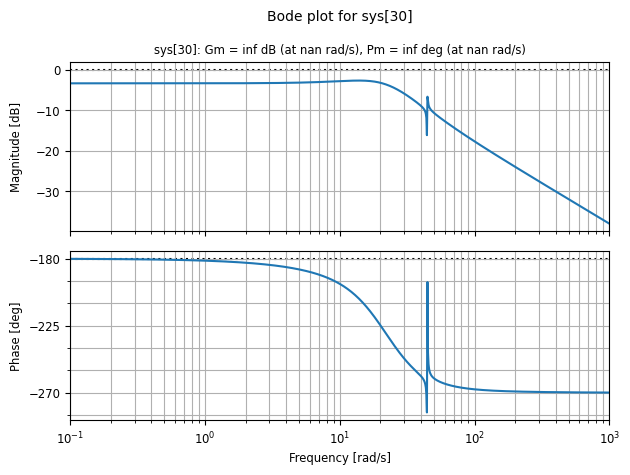

Gain (Magnitude) Margin GM = 1.462 (abs) | 3.3 dB
Phase Margin PM           = inf deg
w_gc (gain crossover)     = 0 rad/s
w_pc (phase crossover)    = nan rad/s


In [110]:
import numpy as np
import control
import matplotlib.pyplot as plt

# ===== 1) SISO plant: u -> stroke =====
# stroke 출력만 (C_s), u 입력만 (B_u)
G_ss = control.ss(A, B_u, C_s, np.array([[0.0]]))
G_tf = control.tf(G_ss)

print("G(s) = stroke/u = (x2-x1)/u")
print(G_tf)

C_pid = control.tf([Kd, Kp], [1])

# ===== 3) Open-loop =====
L = control.series(C_pid, G_tf)

# ===== 4) Bode + margins on plot =====
plt.figure()
control.bode_plot(L, dB=True, Hz=False, omega_limits=(1e-1, 1e3), grid=True, margins=True)
plt.show()

# ===== 5) Numeric margins =====
gm, pm, wgc, wpc = control.margin(L)
gm_db = 20*np.log10(gm) if (gm not in [0, np.inf] and np.isfinite(gm)) else gm

print(f"Gain (Magnitude) Margin GM = {gm:.4g} (abs) | {gm_db:.3g} dB")
print(f"Phase Margin PM           = {pm:.2f} deg")
print(f"w_gc (gain crossover)     = {wgc:.3g} rad/s")
print(f"w_pc (phase crossover)    = {wpc:.3g} rad/s")


모드별 제타

# 3. LQR

3.1 가중치 행렬 설정

In [122]:
q_x1 = 0
q_v1 = 0
q_x2 = 3000
q_v2 = 500

S = np.array([[-1, 0, 1, 0]])  # stroke = x2 - x1
Q_stroke = 1000 * (S.T @ S)                  # stroke^2 가중
Q = np.diag([q_x1, q_v1, q_x2, q_v2]) + Q_stroke

# 제어  가중치 행렬 (작게 하면 제어입력 증가)
R = np.array([[0.01]])

3.2 리카티 해 풀어서 K 구하기

In [123]:
P = solve_continuous_are(A, B_u, Q, R)
K = np.linalg.inv(R) @ (B_u.T @ P)

print("K =", K)

K = [[-938.65419988   23.66461946  306.22577483  196.98138767]]


3.3 모델 설정

In [124]:
def model_LQR(x, t):
    x = np.asarray(x).reshape(4, 1)

    r = road_disp(t)         # 바닥 변위 (m)
    w = impact_force(t)      # 외란 힘 (N)

    u = float(-K @ x)        # 상태피드백

    xdot = (A @ x) + (B_u * u) + (B_r * r) + (B_w * w)
    return xdot.ravel()


3.4 시뮬레이션

In [125]:
t = np.linspace(0, 20, 10000)
init = [0, 0, 0, 0]
sol = odeint(model_LQR, init, t)

x1, v1, x2, v2 = sol.T

stroke_mm = (x2 - x1) * 1000
x2 = x2 * 1000

u_log = np.array([float(-K @ sol[i].reshape(4,1)) for i in range(len(t))])
print(f"max|stroke_mm| = {np.max(np.abs(stroke_mm)):.2f} mm")
print(f"max|x2|        = {np.max(np.abs(x2)):.2f} mm")
print(f"max|u|         = {np.max(np.abs(u_log)):.2f} N")
print(f"F_down         = {F_down:.1f} N")

/tmp/ipython-input-2935437258.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(-K @ x)        # 상태피드백


max|stroke_mm| = 37.84 mm
max|x2|        = 8.78 mm
max|u|         = 40.15 N
F_down         = 9904.5 N


/tmp/ipython-input-2834281480.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_log = np.array([float(-K @ sol[i].reshape(4,1)) for i in range(len(t))])


3.5 시각화

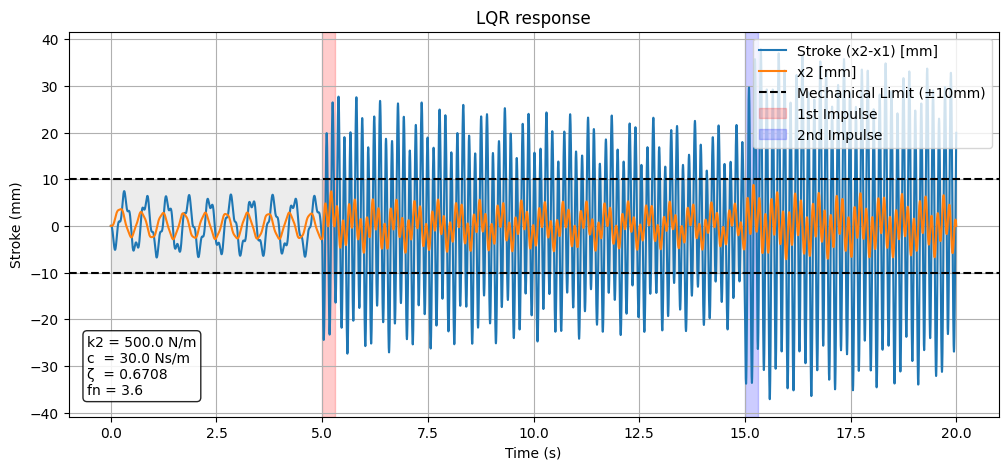

In [126]:
plt.figure(figsize=(12, 5))
plt.plot(t, stroke_mm, linewidth=1.5, label='Stroke (x2-x1) [mm]')
plt.plot(t, x2, linewidth=1.5, label='x2 [mm]')
plt.axhline(y=10, linestyle='--', color='k', label='Mechanical Limit (±10mm)')
plt.axhline(y=-10, linestyle='--', color='k')
plt.fill_between(t, -10, 10, alpha=0.15, color='gray')
plt.axvspan(t_down1, t_down1  +0.3, alpha=0.2, color='red', label='1st Impulse')
plt.axvspan(t_down2, t_down2  +0.3, alpha=0.2, color='blue', label='2nd Impulse')

plt.xlabel('Time (s)')
plt.ylabel('Stroke (mm)')
plt.title('LQR response')
plt.grid(True)
plt.legend(loc='upper right')

param_text = (
    f"k2 = {k2:.1f} N/m\n"
    f"c  = {c:.1f} Ns/m\n"
    f"ζ  = {zeta:.4f}\n"
    f"fn = {f_n:.1f}"
)
ax = plt.gca()
ax.text(
    0.02, 0.05, param_text,
    transform=ax.transAxes,
    va='bottom', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
)
plt.show()